# Loading and Visualizing the MVTec AD Dataset

In [1]:
import fiftyone as fo
import fiftyone.brain as fob 
import fiftyone.zoo as foz 
from fiftyone import ViewField as F 
import fiftyone.utils.huggingface as fouh 

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.current_device())  
print(torch.cuda.get_device_name(0)) 

0
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
dataset = fouh.load_from_hub("Voxel51/mvtec-ad", persistent=True, overwrite=True)

c:\Users\AD\miniconda3\envs\anomalib_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset
Importing samples...
 100% |███████████████| 5354/5354 [198.5ms elapsed, 0s remaining, 27.2K samples/s] 
Migrating dataset 'Voxel51/mvtec-ad' to v1.2.0


Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



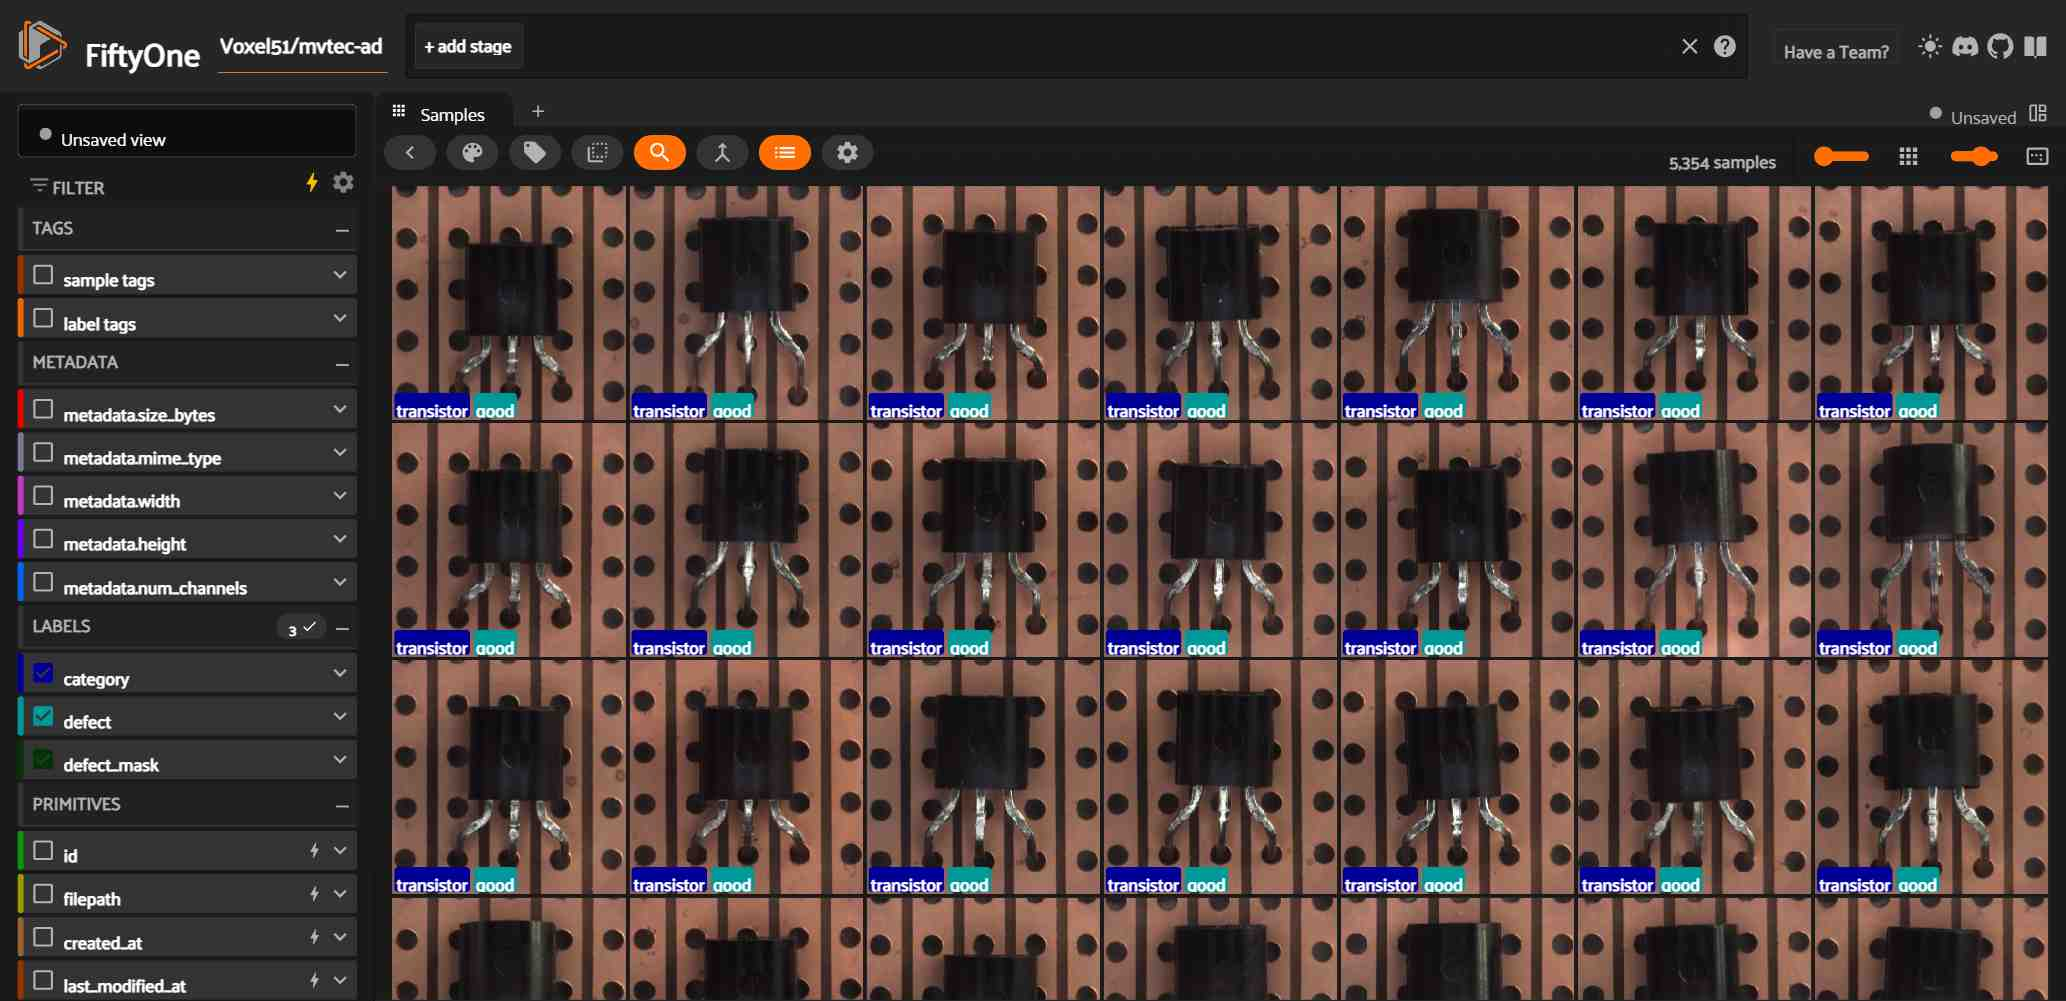

In [4]:
session = fo.launch_app(dataset)

In [5]:
model = foz.load_zoo_model("resnet50-imagenet-torch")

# Compute embeddings for the dataset
dataset.compute_embeddings(
    model=model, embeddings_field="resnet50_embeddings", device=device
)

# Dimensionality reduction using UMAP on the embeddings
fob.compute_visualization(
    dataset, embeddings="resnet50_embeddings", method="umap", brain_key="resnet50_vis"
)

 100% |███████████████| 5354/5354 [5.2m elapsed, 0s remaining, 18.6 samples/s]      
Generating visualization...


c:\Users\AD\miniconda3\envs\anomalib_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Tue Jan 14 01:06:19 2025 Construct fuzzy simplicial set
Tue Jan 14 01:06:19 2025 Finding Nearest Neighbors
Tue Jan 14 01:06:19 2025 Building RP forest with 9 trees
Tue Jan 14 01:06:22 2025 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Tue Jan 14 01:06:29 2025 Finished Nearest Neighbor Search
Tue Jan 14 01:06:31 2025 Construct embedding


Epochs completed:  37%| ███▋       185/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  76%| ███████▋   382/500 [00:01]

	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jan 14 01:06:33 2025 Finished embedding


# Training an Anomaly Detection Model

In [6]:
import numpy as np
import os
from pathlib import Path
from PIL import Image
from torchvision.transforms.v2 import Resize

from anomalib import TaskType
from anomalib.data.image.folder import Folder
from anomalib.deploy import ExportType, OpenVINOInferencer
from anomalib.engine import Engine
from anomalib.models import Padim, Patchcore

In [7]:
dataset.distinct("category.label")

['bottle',
 'cable',
 'capsule',
 'carpet',
 'grid',
 'hazelnut',
 'leather',
 'metal_nut',
 'pill',
 'screw',
 'tile',
 'toothbrush',
 'transistor',
 'wood',
 'zipper']

In [8]:
OBJECT = "transistor" 
ROOT_DIR = Path("D:/anomaly_detection/mvtec_ad") 
TASK = TaskType.SEGMENTATION 
IMAGE_SIZE = (256, 256) 

In [9]:
def create_datamodule(object_type, transform=None):
    ## Build transform
    if transform is None:
        transform = Resize(IMAGE_SIZE, antialias=True)
    
    normal_data = (
        dataset.match(F("category.label") == object_type)
        .match(F("split") == "train")
        .match(F("defect.label") == "good")
    )
    abnormal_data = (
        dataset.match(F("category.label") == object_type)
        .match(F("split") == "test")
        .match(F("defect.label") != "good")
    )
    
    normal_dir = Path(ROOT_DIR) / object_type / "normal"
    abnormal_dir = ROOT_DIR / object_type / "abnormal"
    mask_dir = ROOT_DIR / object_type / "mask"
    
    # Create directories if they do not exist
    normal_dir.mkdir(parents=True, exist_ok=True)
    abnormal_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)
    
    if not os.path.exists(normal_dir):
        normal_data.export(
            export_dir=str(normal_dir),
            dataset_type=fo.types.ImageDirectory,
            export_media="symlink",
        )
    
    for sample in abnormal_data.iter_samples():
        base_filename = Path(sample.filename).name
        dir_name = Path(sample.filepath).parent.name
        new_filename = f"{dir_name}_{base_filename}"
        
        abnormal_path = abnormal_dir / new_filename
        mask_path = mask_dir / new_filename

        # Handle symlink creation for abnormal images
        if not abnormal_path.exists():
            try:
                os.symlink(sample.filepath, str(abnormal_path))
                print(f"Created symlink: {abnormal_path}")
            except FileExistsError:
                print(f"Symlink already exists for: {abnormal_path}")
            except OSError as e:
                print(f"Error creating symlink for {abnormal_path}: {e}")
        
        # Handle symlink creation for masks
        if not mask_path.exists() and sample.defect_mask:
            try:
                os.symlink(sample.defect_mask.mask_path, str(mask_path))
                print(f"Created mask symlink: {mask_path}")
            except FileExistsError:
                print(f"Symlink already exists for: {mask_path}")
            except OSError as e:
                print(f"Error creating symlink for {mask_path}: {e}")


    
    ## Create a DataModule in Anomalib
    datamodule = Folder(
        name=object_type,
        root=ROOT_DIR,
        normal_dir=normal_dir,
        abnormal_dir=abnormal_dir,
        mask_dir=mask_dir,
        task=TASK,
        transform=transform
    )
    datamodule.setup()
    return datamodule


In [11]:
def train_and_export_model(object_type, model, transform=None):
    ## Train model on our data
    datamodule = create_datamodule(object_type, transform=transform)
    engine = Engine(task=TASK)
    engine.fit(model=model, datamodule=datamodule)
    
    ## Export model into OpenVINO format for fast inference
    engine.export(
        model=model,
        export_type=ExportType.OPENVINO,
    )
    output_path = Path(engine.trainer.default_root_dir)
    openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
    metadata = output_path / "weights" / "openvino" / "metadata.json"
    
    ## Load the inference object from export
    inferencer = OpenVINOInferencer(
        path=openvino_model_path,
        metadata=metadata,
        device="CPU",
    )
    return inferencer

In [12]:
# Padim model
model = Padim()
inferencer = train_and_export_model(OBJECT, model)

INFO:anomalib.models.components.base.anomaly_module:Initializing Padim model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium

Epoch 0:  71%|███████▏  | 5/7 [00:09<00:03,  0.53it/s]

c:\Users\AD\miniconda3\envs\anomalib_env\lib\site-packages\lightning\pytorch\loops\optimization\automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 0: 100%|██████████| 7/7 [00:09<00:00,  0.74it/s]

INFO:anomalib.models.image.padim.lightning_model:Aggregating the embedding extracted from the training set.
INFO:anomalib.models.image.padim.lightning_model:Fitting a Gaussian to the embedding collected from the training set.


Epoch 0: 100%|██████████| 7/7 [00:24<00:00,  0.29it/s, pixel_AUROC=0.954, pixel_F1Score=0.0526]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 7/7 [00:24<00:00,  0.28it/s, pixel_AUROC=0.954, pixel_F1Score=0.0526]


INFO:anomalib.callbacks.timer:Training took 28.18 seconds
c:\Users\AD\miniconda3\envs\anomalib_env\lib\site-packages\torch\onnx\_internal\jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\jit\passes\onnx\constant_fold.cpp:180.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
c:\Users\AD\miniconda3\envs\anomalib_env\lib\site-packages\torch\onnx\utils.py:663: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\jit\passes\onnx\constant_fold.cpp:180.)
  _C._jit_pass_onnx_graph_shape_type_inference(
c:\Users\AD\miniconda3\envs\anomalib_env\lib\site-packages\torch\onnx\utils.py:1186: UserWar

In [13]:
def run_inference(sample_collection, inferencer, key, threshold=0.5):
    for sample in sample_collection.iter_samples(autosave=True, progress=True):
        output = inferencer.predict(image=Image.open(sample.filepath))
        
        conf = output.pred_score
        anomaly = "normal" if conf < threshold else "anomaly"
        sample[f"pred_anomaly_score_{key}"] = conf
        sample[f"pred_anomaly_{key}"] = fo.Classification(label=anomaly)
        sample[f"pred_anomaly_map_{key}"] = fo.Heatmap(map=output.anomaly_map)
        sample[f"pred_defect_mask_{key}"] = fo.Segmentation(mask=output.pred_mask)

 100% |█████████████████| 100/100 [26.1s elapsed, 0s remaining, 3.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [26.1s elapsed, 0s remaining, 3.9 samples/s]      



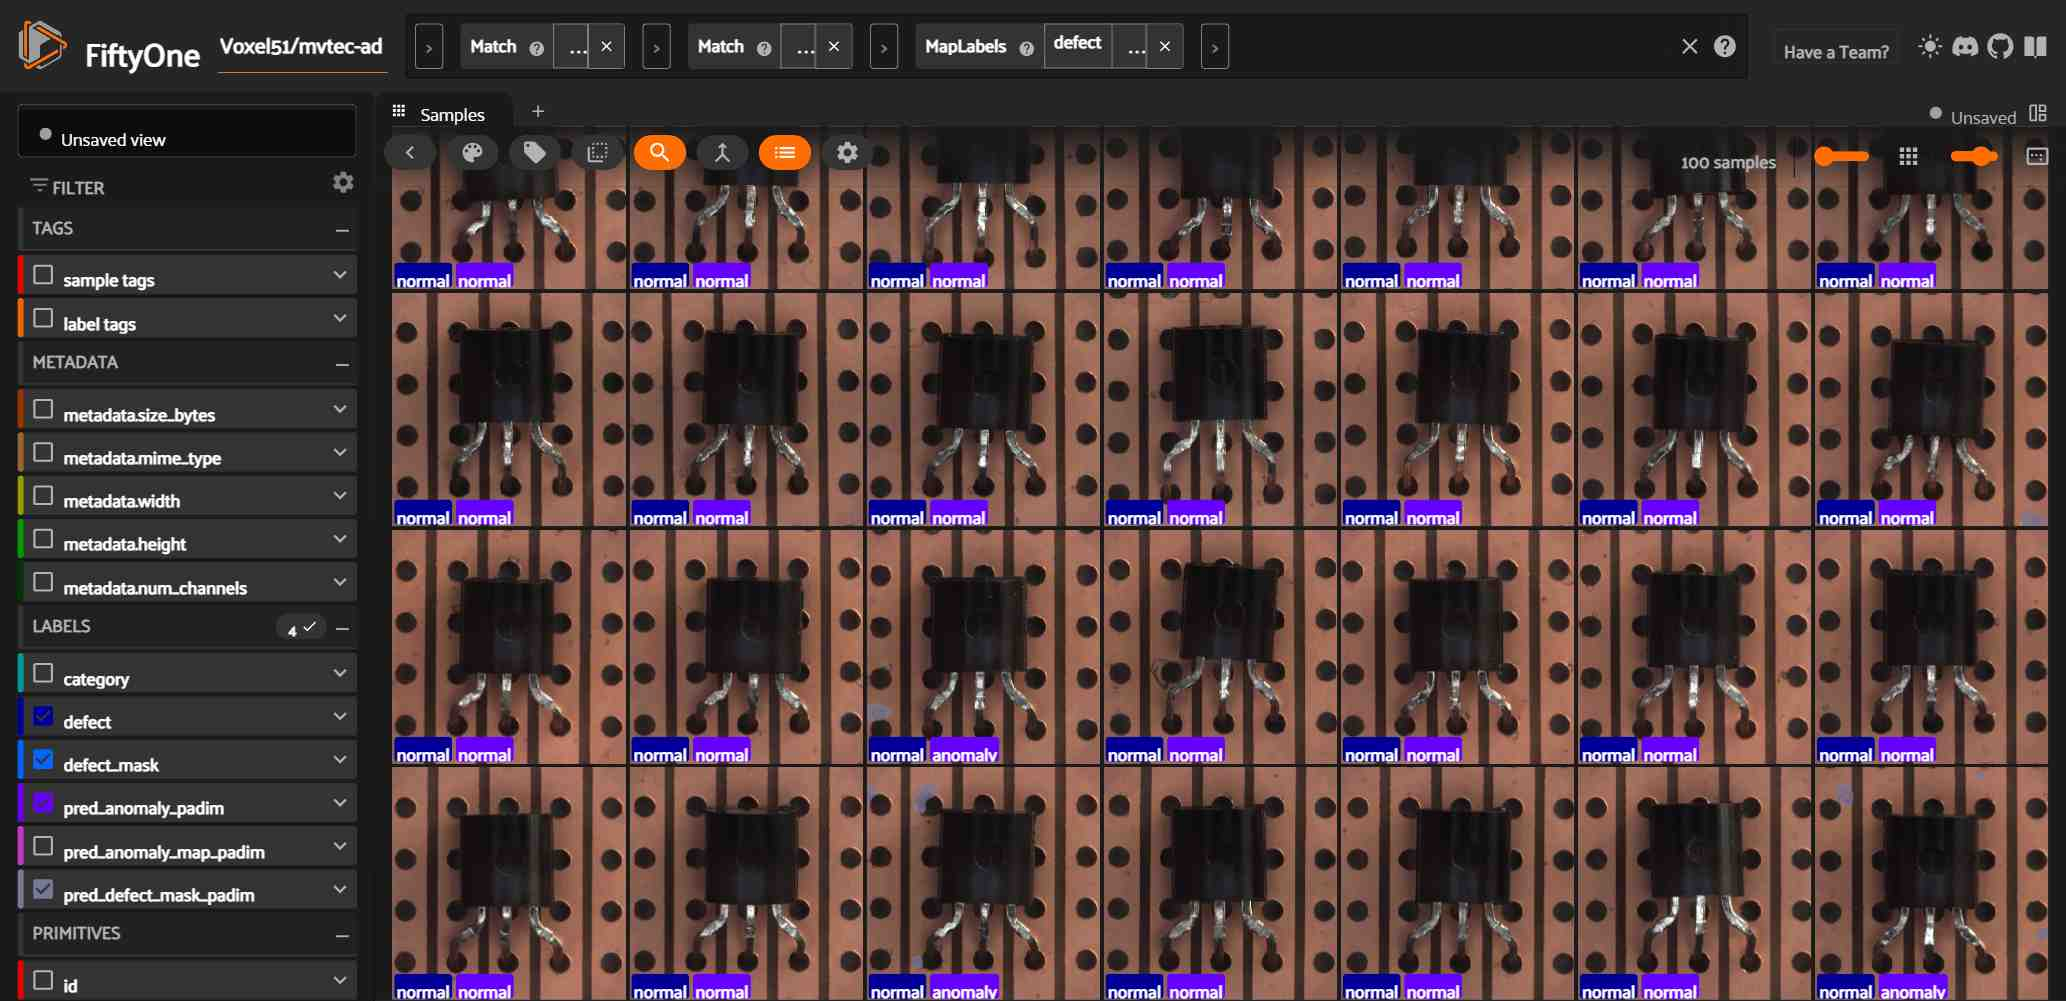

In [14]:
## get the test split of the dataset
test_split = dataset.match(F("category.label") == OBJECT).match(F("split") == "test")

run_inference(test_split, inferencer, "padim")
session = fo.launch_app(view=test_split)

In [15]:
for sample in test_split.iter_samples(autosave=True, progress=True):
    if sample["defect"].label == "good":
        sample["defect_mask"] = fo.Segmentation(
            mask=np.zeros_like(sample["pred_defect_mask_padim"].mask)
        )

 100% |█████████████████| 100/100 [21.1s elapsed, 0s remaining, 4.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [21.1s elapsed, 0s remaining, 4.7 samples/s]      



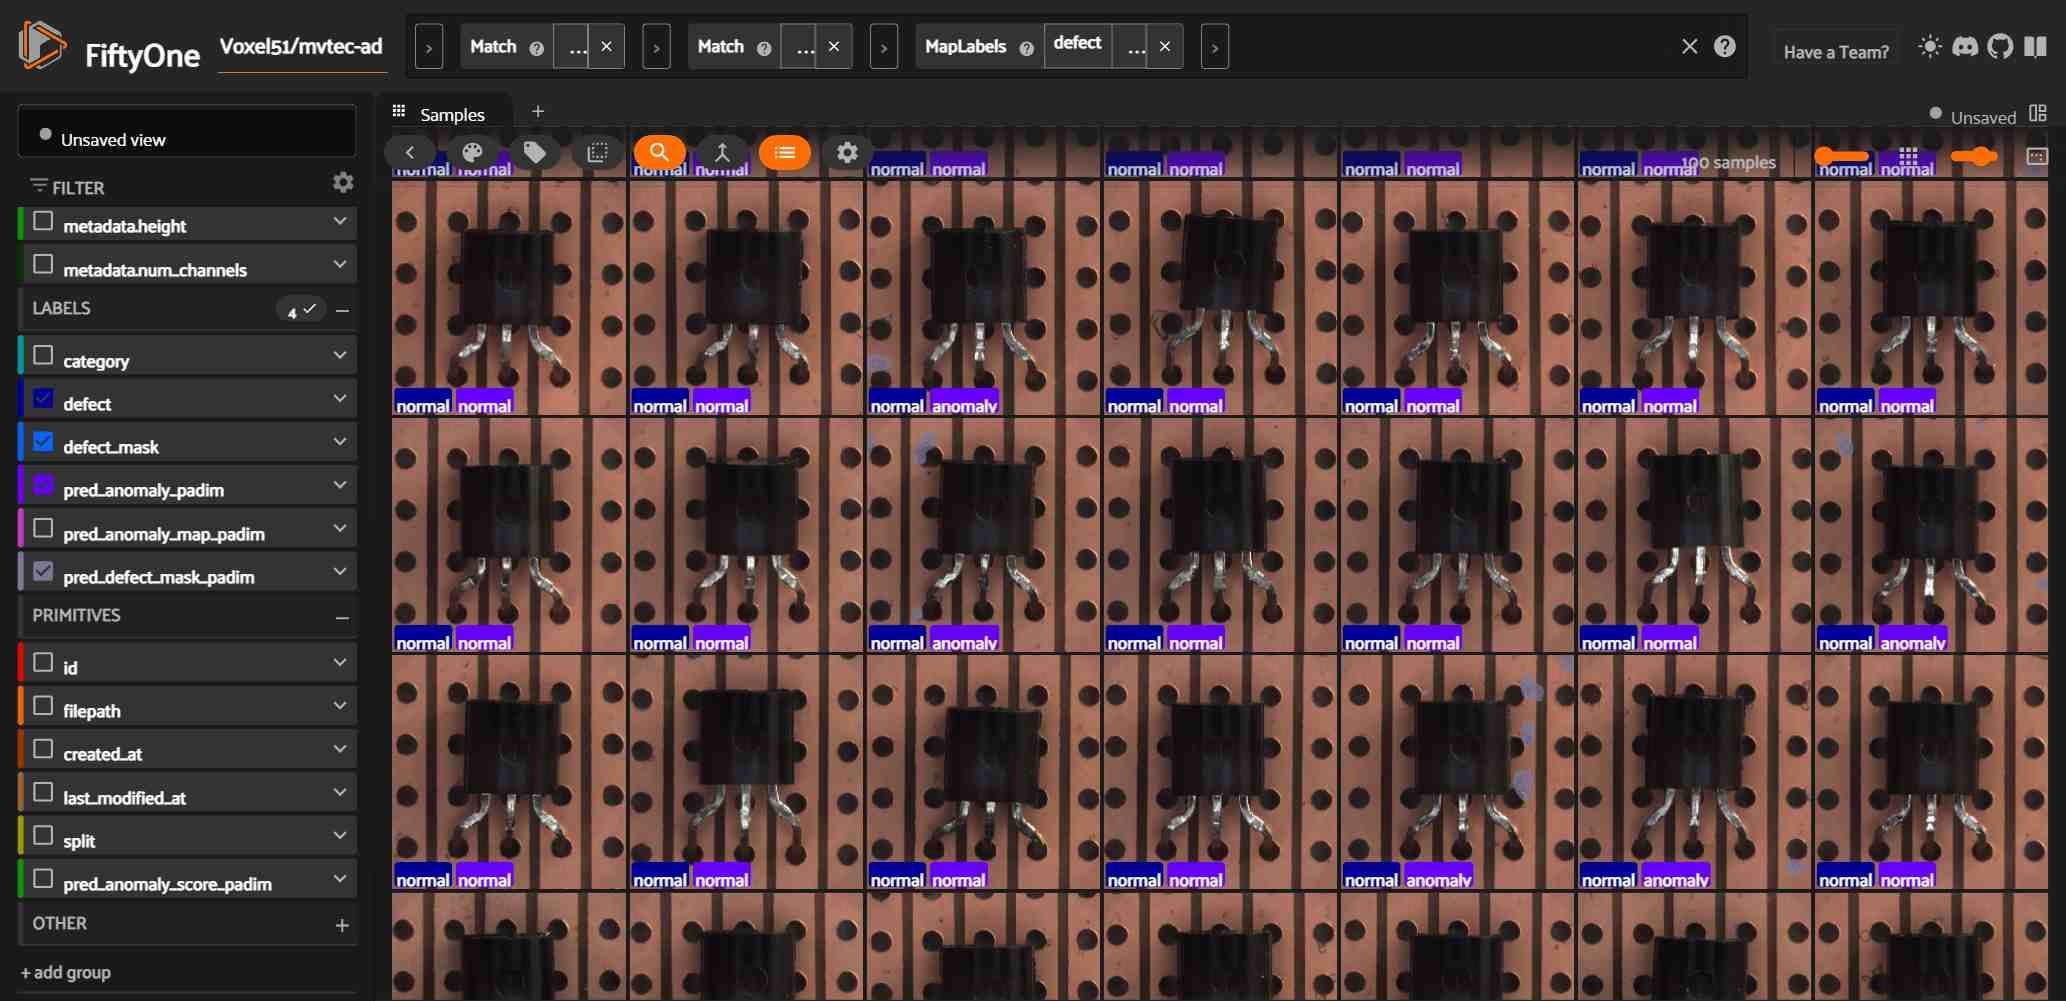

In [16]:
old_labels = test_split.distinct("defect.label")
label_map = {label:"anomaly" for label in old_labels if label != "good"}
label_map["good"] = "normal"
mapped_view = test_split.map_labels("defect", label_map)
session.view = mapped_view.view()

In [17]:
eval_classif_padim = mapped_view.evaluate_classifications(
    "pred_anomaly_padim",
    gt_field="defect",
    eval_key="eval_classif_padim",
    method="binary",
    classes=["normal", "anomaly"],
)
eval_classif_padim.print_report()

              precision    recall  f1-score   support

      normal       0.92      0.92      0.92        60
     anomaly       0.88      0.88      0.88        40

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [18]:
eval_seg_padim = mapped_view.evaluate_segmentations(
    "pred_defect_mask_padim",
    gt_field="defect_mask",
    eval_key="eval_seg_padim",
)
eval_seg_padim.print_report(classes=[0, 255])

Computing possible mask values...


INFO:fiftyone.utils.eval.segmentation:Computing possible mask values...


 100% |█████████████████| 100/100 [7.8s elapsed, 0s remaining, 13.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [7.8s elapsed, 0s remaining, 13.1 samples/s]      


Evaluating segmentations...


INFO:fiftyone.utils.eval.segmentation:Evaluating segmentations...


 100% |█████████████████| 100/100 [29.4s elapsed, 0s remaining, 3.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [29.4s elapsed, 0s remaining, 3.4 samples/s]      


              precision    recall  f1-score   support

           0       0.98      0.98      0.98 99831567.0
         255       0.65      0.62      0.63 5026033.0

   micro avg       0.97      0.97      0.97 104857600.0
   macro avg       0.82      0.80      0.81 104857600.0
weighted avg       0.97      0.97      0.97 104857600.0

